# Part 1 | ESG Factor Establishment 

### Importing Packages

In [1]:
import shutil 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

The indices (stocks) underlying the ETFs IVV, IJH and IJR are used for factor establishment as those collectively provide comprehensive coverage of large, mid, and small-cap U.S. equities, offering a well-diversified representation of the entire US.

1. IVV: iShares Core S&P 500 ETF
2. IJH: iShares Core S&P Mid-Cap ETF
3. IJR: iShares Core S&P Small-Cap ETF

### Importing Data

In [2]:
# Importing data of esg scores of each stock we investigate
esg_score_import = pd.read_csv('__data/esg_score.csv', delimiter=",") 

# Importing data of closing prices of each stock we investigate
price_close_import = pd.read_csv('__data/price_close.csv', delimiter=",")

# **Part I: Creating Factor**

### Preparing Data

In [3]:
'''
Ensure data consistency and prepare for analysis.
We retain only those stocks (columns) that have data for both ESG scores and closing prices in both datasets.
''' 

# Change data type of date to datetime
esg_score_import["Date"] = pd.to_datetime(esg_score_import["Date"])
price_close_import["Date"] = pd.to_datetime(price_close_import["Date"])

# Sort columns alphabetically
esg_score_import = esg_score_import[sorted(esg_score_import.columns)]
price_close_import = price_close_import[sorted(price_close_import.columns)]

# Get one row per month
esg_score = esg_score_import.resample("M", on = "Date").mean() # ME or M
price_close = price_close_import.resample("M", on = "Date").mean() # ME or M

# Drop columns that are not in both tables
common_columns = esg_score.columns.intersection(price_close.columns).tolist()

esg_score = esg_score[common_columns]
price_close = price_close[common_columns]

# Fill missing rows with previous values for esg score
esg_score.fillna(method='ffill', inplace=True)

### Calculating Monthly Returns

In [4]:
price_close_returns = price_close.drop(columns=["Date"], errors='ignore').pct_change()

### Creating Portfolios & Calculating ESG Factor

In [5]:
# Function Returns the Portfolio with the ESG Score of a certain percentile for each date
def getESGScorePercentile(esg_score_data, percentile, high = True):
    stock_list = []

    # Loops over each date
    for date in esg_score_data.index:
        esg_scores = esg_score_data.loc[date] # Gets corresponding esg scores
        esg_scores = esg_scores.dropna(axis=0) # Drops any missing values

        # Creates Portfolio
        if high:
            percentile_stocks = esg_scores.nlargest(int(len(esg_scores) * percentile / 100)).index.tolist()
        else:
            percentile_stocks = esg_scores.nsmallest(int(len(esg_scores) * percentile / 100)).index.tolist()

        # Counts stocks in portfolio
        count = len(percentile_stocks)

        # Appends to list
        stock_list.append((date, percentile_stocks, count))

    # Creates new dataframe
    stock_list_dataframe = pd.DataFrame(stock_list, columns=['Date', 'Stock_List', 'Stock_Count'])
    stock_list_dataframe.set_index("Date", inplace = True)

    # Returns dataframe
    return stock_list_dataframe

# Calculates portfolio return for a specific date & list of stocks
def getPortfolioReturn(return_data, date, list_stocks):
    returns = return_data.loc[date]
    returns = returns[list_stocks]

    return returns

# Calculates return history
def calculateReturnHistory(return_data, portfolio_data, column_name_return, column_name_count):

    average_returns = []

    # Loops over each date
    for date in portfolio_data.index:

        # Gets list of stocks & count of stocks
        currentStockList = portfolio_data.loc[date]["Stock_List"]
        currentStockCount = portfolio_data.loc[date]["Stock_Count"]

        # Gets return of list of stocks at current date
        stock_returns = getPortfolioReturn(return_data, date, currentStockList)

        # Calculates average return (EQUAL WEIGHTED)
        if len(stock_returns) > 0:
            average_portfolio_return = stock_returns.mean()
        else:
            average_portfolio_return = float('nan')

        # Adds return to list
        average_returns.append((date, average_portfolio_return, currentStockCount))

    # Returns dataframe
    return pd.DataFrame(average_returns, columns=["Date", column_name_return, column_name_count])

In [6]:
# Returns dataframe containing the ESG Portfolios for each date
highest_stocks = getESGScorePercentile(esg_score, 25, high = True)
lowest_stocks = getESGScorePercentile(esg_score, 25, high = False)

# Calculates the Average Return for each Portfolio at each Date
highest_stocks_average_return = calculateReturnHistory(price_close_returns, highest_stocks, "Average_Return_High", "Count_High")
lowest_stocks_average_return = calculateReturnHistory(price_close_returns, lowest_stocks, "Average_Return_Low", "Count_Low")

# Merges Data together to have the data in one dataframe
return_history = pd.merge(highest_stocks_average_return, lowest_stocks_average_return, on='Date', how='outer')

# Calculates Factor for each Date
return_history["ESG_Factor"] = return_history["Average_Return_Low"] - return_history["Average_Return_High"]

# Exports Data as CSV
#.to_csv('return_history.csv', index=False)

In [7]:
return_history.head()

,Date,Average_Return_High,Count_High,Average_Return_Low,Count_Low,ESG_Factor
0,2002-01-31,0.100080,1,-0.017339,1,-0.117420
1,2002-02-28,0.032749,3,-0.018284,3,-0.051034
2,2002-03-31,0.047315,4,0.031032,4,-0.016283
3,2002-04-30,-0.042787,5,-0.091201,5,-0.048415
4,2002-05-31,-0.021876,7,-0.040302,7,-0.018426


# **Part II: Inspecting Factor**

In [8]:
return_history_inspect = return_history[return_history["Count_High"] > 50].copy() # Only look at diversified portfolios

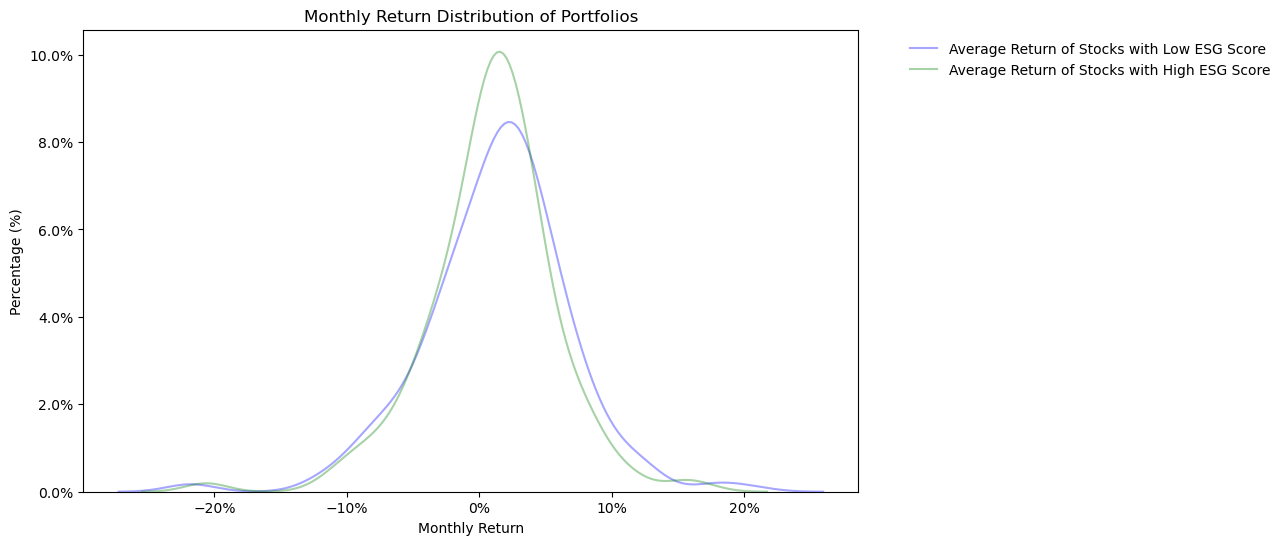

In [9]:
plt.figure(figsize=(10, 6), dpi=100)

sns.kdeplot(return_history_inspect['Average_Return_Low'], color='blue', label='Average Return of Stocks with Low ESG Score', fill=False, alpha=0.35)
sns.kdeplot(return_history_inspect['Average_Return_High'], color='green', label='Average Return of Stocks with High ESG Score', fill=False, alpha=0.35)

plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))

# Add labels and title
plt.xlabel('Monthly Return')
plt.ylabel('Percentage (%)')
plt.title('Monthly Return Distribution of Portfolios')

# Add legend
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

# Remove Grid
plt.grid(visible = False)

# Show plot
plt.show()

Both distributions are bell-shaped, indicating that most monthly returns are clustered around the mean, with fewer extreme returns on either side. The distributions for both the low and high esg score portfolios are quite similar, suggesting that the overall return patterns are comparable. 

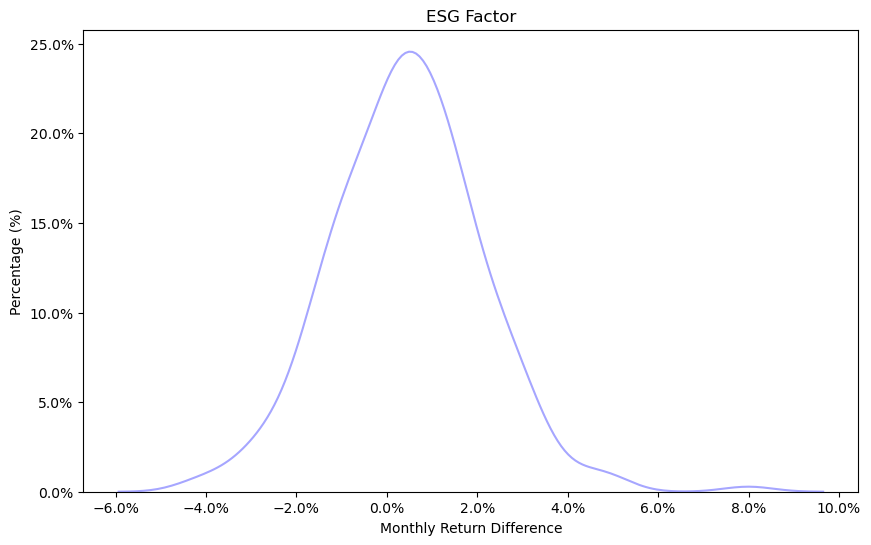

In [10]:
plt.figure(figsize=(10, 6), dpi=100)

sns.kdeplot(return_history_inspect['ESG_Factor'], color='blue', fill=False, alpha=0.35)

plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))

# Add labels and title
plt.xlabel('Monthly Return Difference')
plt.ylabel('Percentage (%)')
plt.title('ESG Factor')

# Remove Grid
plt.grid(visible = False)

# Show plot
plt.show()

The ESG factor, the difference in monthly returns between stocks with low ESG score and stocks with high ESG score, also exhibits a bell-shaped distribution without significant bias towards either high or low esg score stocks. The peak is near zero, indicating that in most months, the difference in returns between low and high ESG score portfolios is very small. This implies that there is generally little difference in performance between those two groups of stocks.

### Simulation 

In [11]:
# Imagine an initial investment of a specific amount
initial_investment = 100

# Calculate cumulative growth factor for each stock
return_history_inspect["Portfolio_Value_High"] = initial_investment * (1 + return_history_inspect["Average_Return_High"]).cumprod()
return_history_inspect["Portfolio_Value_Low"] = initial_investment * (1 + return_history_inspect["Average_Return_Low"]).cumprod()

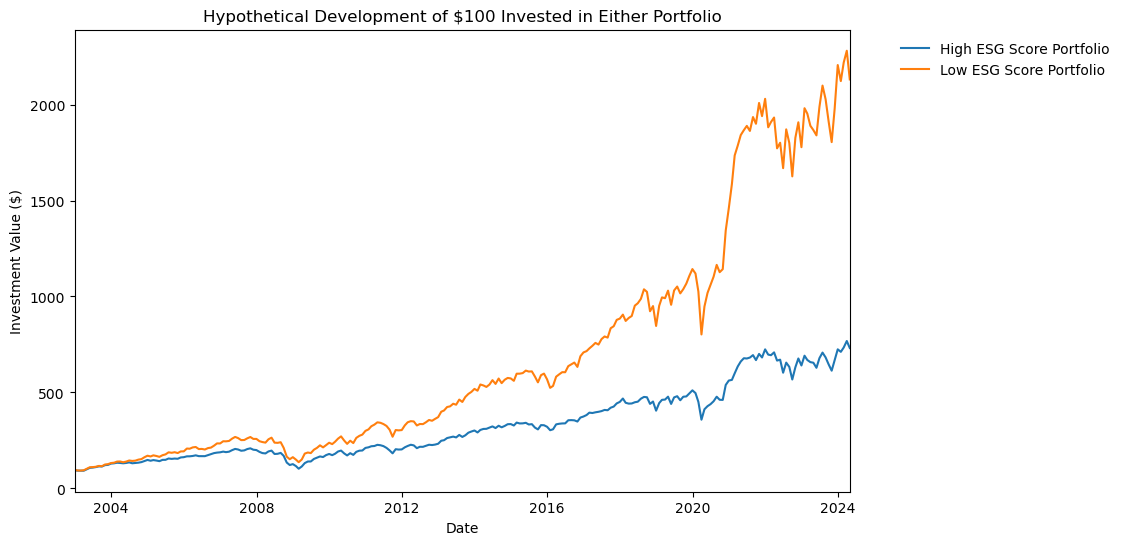

In [12]:
# Plot the investment growth for each stock over time
plt.figure(figsize=(10, 6))

sns.lineplot(y = "Portfolio_Value_High", x = "Date", label = "High ESG Score Portfolio", data = return_history_inspect)
sns.lineplot(y = "Portfolio_Value_Low", x = "Date", label = "Low ESG Score Portfolio", data = return_history_inspect)

# Adding labels and title
plt.title(f"Hypothetical Development of ${initial_investment} Invested in Either Portfolio")

plt.xlabel("Date")
plt.ylabel("Investment Value ($)")

plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

plt.grid(visible = False)
plt.xlim(return_history_inspect["Date"].min(), return_history_inspect["Date"].max())

plt.show()

The plot highlights a key trade-off between higher returns and increased volatility for portfolios with low ESG scores versus lower returns and greater stability for portfolios with high ESG scores. This suggests that while low ESG stocks may offer better short-term gains, they come with higher risk, whereas high ESG stocks may appeal with smaller gains but steady growth.